<a href="https://colab.research.google.com/github/angelsar98/Trabajo-Final-ML-2023/blob/main/Trabajo_Final_ML_(Seleccion%2C_entrenamiento_y_evaluacion_de_modelos).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Trabajo Final Machine Learning Parte 2**

> ## *Estimador de precios de AirBnb*

---

> Realizado por: Ángel Sarriá Jiménez y Silvia Gamundi Sumando

https://github.com/angelsar98/Trabajo-Final-ML-2023/tree/main

# 0. Carga de datos y librerías

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as ss
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,ParameterGrid,RepeatedKFold
from sklearn import preprocessing
from sklearn.linear_model import Lasso,Ridge,LogisticRegression,LinearRegression
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
import multiprocessing
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/airbnb-listings-extract-limpio.csv',sep=';',index_col=0)
#df=pd.read_csv('/content/airbnb-listings-extract-limpio.csv',sep=';',index_col=0)
df

,Price,Host Since,Host Response Rate,Host Total Listings Count,Latitude,Longitude,Property Type,Accommodates,Bathrooms,Bedrooms,...,Require Guest Profile Picture,Require Guest Phone Verification,Entire_home_apt,Shared_room,Real_Bed,Updated_less_one_month,Updated_more_one_month,Updated_today,flexible,moderate
0,149.0,7.0,99.000000,207.0,41.388685,2.155150,0,5,1.0,2.0,...,0,0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,106.0,7.0,99.000000,207.0,41.382537,2.149577,0,6,1.0,2.0,...,0,0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,45.0,11.0,100.000000,1.0,41.402357,2.171119,0,2,1.0,1.0,...,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,100.0,8.0,100.000000,1.0,52.366679,4.865595,0,2,1.0,1.0,...,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,115.0,10.0,90.000000,1.0,41.381369,2.180874,0,3,2.0,1.0,...,0,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12330,25.0,7.0,83.000000,4.0,40.385395,-3.669958,8,7,1.0,2.0,...,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
12331,50.0,7.0,100.000000,4.0,40.405239,-3.638197,0,6,1.0,3.0,...,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
12332,16.0,8.0,60.000000,2.0,40.408779,-3.650200,0,1,1.0,1.0,...,0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
12333,120.0,10.0,94.845885,2.0,39.896533,3.076243,0,6,1.0,2.0,...,0,0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12335 entries, 0 to 12334
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Price                             12335 non-null  float64
 1   Host Since                        12335 non-null  float64
 2   Host Response Rate                12335 non-null  float64
 3   Host Total Listings Count         12335 non-null  float64
 4   Latitude                          12335 non-null  float64
 5   Longitude                         12335 non-null  float64
 6   Property Type                     12335 non-null  int64  
 7   Accommodates                      12335 non-null  int64  
 8   Bathrooms                         12335 non-null  float64
 9   Bedrooms                          12335 non-null  float64
 10  Beds                              12335 non-null  float64
 11  Security Deposit                  12335 non-null  float64
 12  Clea

# 1. Selección y evaluación del modelos

En este notebook vamos a entrenar y evaluar los distintos modelos requeridos.

Nuestro objetivo es construir un estimador de precios en función de las distintas características del Airbnb. Además, usaremos una regresión logística para complementar el evaluador de precios con un modelo que nos diga si el Airbnb tiene o no disponibilidad alta.

Para ello, necesitaremos realizar una serie de pasos:

En primer lugar, necesitamos dividir nuestros datos en 2 conjuntos denominados de entrenamiento y de test. El conjunto de entrenamiento será el que utilicemos para entrenar nuestros modelos, es decir, encontrar los parámetros más adecuados para nuestros datos. El conjunto de test será el que empleemos para evaluar el modelo previamente entrenado. Cada uno de estos nos dará un error en función de las distintas métricas evaluadas. El error de entrenamiento nos servirá para elegir con qué parámetros nos quedamos en el entrenamiento del modelo y el error de generalización (test) nos servirá para comparar los distintos modelos y quedarnos con el mejor de ellos.

Tras realizar las particiones necesarias en el conjunto de datos, presentaremos las métricas escogidas para evaluar los modelos:
- **RMSE** (root mean squared error): es la raíz cuadrada de la media de los errores al cuadrado. Nos dice cuanto se desvía, en media, la predicción que hacemos del valor real
- **MSE**: es la media de los errores al cuadrado. Nos dice cuanto se desvía, en media, la predicción que hacemos del valor real
- **$R^2$ score**: representa el porcentaje de varianza explicada por el modelo
- **MAE** (mean absolute error): similar al MSE, es la media de los errores en valor absoluto. 

La principal diferencia entre RMSE y MAE es que el RMSE penaliza mucho los errores grandes, mientras que el MAE los trata a todos por igual.

Estas métricas nos servirán para evaluar los modelos de regresión, es decir LASSO, Ridge, Regresión Múltiple y Support Vector Machine.

## 1.0 Consideraciones iniciales


Particionamos el conjunto de datos en un subconjunto de entrenamiento y otro de test. Para ello, primero escribimos el dataset en formato array:

In [ ]:
data = df.values 

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = df.columns[1:]

In [ ]:
#Usamos StandardScaler para estandarizar los datos
scaled_features = StandardScaler().fit_transform(X, y)

In [ ]:
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.iloc[:,1:].columns)
scaled_features_df['Price']= y
scaled_features_df.head()

,Host Since,Host Response Rate,Host Total Listings Count,Latitude,Longitude,Property Type,Accommodates,Bathrooms,Bedrooms,Beds,...,Require Guest Phone Verification,Entire_home_apt,Shared_room,Real_Bed,Updated_less_one_month,Updated_more_one_month,Updated_today,flexible,moderate,Price
0,-1.029626,0.279649,7.007328,0.458549,0.926851,-0.380202,1.353587,-0.375841,1.310284,0.241117,...,-0.156258,0.833846,-0.092658,0.147026,-0.654085,-0.45686,1.733081,1.430010,-0.666364,149.0
1,-1.029626,0.279649,7.007328,0.455521,0.925972,-0.380202,2.003661,-0.375841,1.310284,1.193464,...,-0.156258,0.833846,-0.092658,0.147026,1.528853,-0.45686,-0.577007,-0.699296,-0.666364,106.0
2,1.446938,0.356166,-0.295494,0.465282,0.929370,-0.380202,-0.596634,-0.375841,-0.282537,-0.711230,...,-0.156258,-1.199262,-0.092658,0.147026,-0.654085,-0.45686,-0.577007,1.430010,-0.666364,45.0
3,-0.410485,0.356166,-0.295494,5.865328,1.354453,-0.380202,-0.596634,-0.375841,-0.282537,-0.711230,...,-0.156258,-1.199262,-0.092658,0.147026,1.528853,-0.45686,-0.577007,-0.699296,1.500681,100.0
4,0.827797,-0.409008,-0.295494,0.454945,0.930909,-0.380202,0.053439,1.686437,-0.282537,-0.711230,...,-0.156258,0.833846,-0.092658,0.147026,1.528853,-0.45686,-0.577007,1.430010,-0.666364,115.0


Los coeficientes de regresión del modelo son los que controlan la influencia de cada predictor en el modelo. Sin embargo, la magnitud de cada coeficiente depende de las unidades en las que se midan los predictores, por lo que su magnitud no está asociada con la importancia de cada predictor. Para poder considerar que, cuanto más próximo a cero es el coeficiente un predictor, menor es su influencia sobre la variable respuesta en comparación al resto, es necesario estandarizar todos los predictores antes de ajustar el modelo.


In [ ]:
X_sc = scaled_features_df.iloc[:, 0:38].values
y_sc = scaled_features_df['Price'].values

from sklearn.model_selection import train_test_split

X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc, test_size=0.25, random_state=0)

X_train_sc.shape, X_test_sc.shape

((9251, 38), (3084, 38))

In [ ]:
#Para guardar las metricas de cada modelo
vector_rmse=[]
vector_mse=[]
vector_mae=[]
vector_r2_score=[]

Con el fin de que la predicción esté lo menos influida posible por la partición de los datos realizada, comprobaremos si las proporciones de la variable respuesta es la misma en los conjuntos de entrenamiento y test.

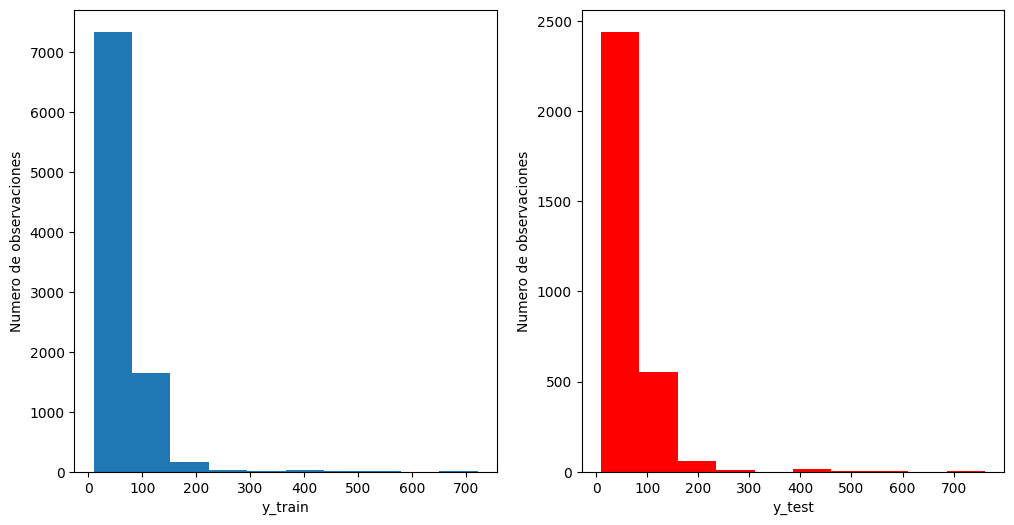

In [ ]:
fig , ax = plt.subplots(1,2,figsize=(12,6))

ax[0].hist(y_train_sc)
ax[0].set_xlabel('y_train')
ax[0].set_ylabel('Numero de observaciones')

ax[1].hist(y_test_sc,color='r')
ax[1].set_xlabel('y_test')
ax[1].set_ylabel('Numero de observaciones')

plt.show()

## 1.1 Regresion LASSO

LASSO (Least Absolute Shrinkage and Selection Operator) es un modelo lineal que penaliza el vector de coeficientes añadiendo su norma L1 (basada en la distancia Manhattan) a la función de coste:

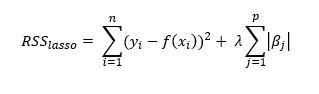

El grado de penalización está controlado por el hiperparámetro  λ
 . Cuando  λ=0
 , el resultado es equivalente al de un modelo lineal por mínimos cuadrados.

In [ ]:
alpha_vector = np.logspace(-10,1,25)
grid = GridSearchCV(Lasso(),param_grid = {'alpha': alpha_vector}, 
        scoring='neg_root_mean_squared_error',
        n_jobs= multiprocessing.cpu_count() - 1,
        cv= RepeatedKFold(n_splits=10, n_repeats=7, random_state=123), 
        refit=True,verbose= 0,return_train_score = True)
grid.fit(X_train_sc, y_train_sc)

# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'alpha': 0.051089697745069135} : -40.04634089789855 neg_root_mean_squared_error


,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
19,0.05109,-40.046341,5.288612,-40.167606,0.587379
18,0.017783,-40.047351,5.275947,-40.165550,0.587398
17,0.00619,-40.048167,5.271465,-40.165299,0.587400
16,0.002154,-40.048505,5.269902,-40.165268,0.587401


In [ ]:
modelo_LASSO = grid.best_estimator_
y_pred = modelo_LASSO.predict(X = X_test_sc)
# Veamos los coeficientes obtenidos
print('Coefficients: \n', modelo_LASSO.coef_)
# Termino independiente
print('Independent term: \n', modelo_LASSO.intercept_)
# Error Cuadrado Medio
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test_sc, y_pred)))
print("MSE: %.2f" % mean_squared_error(y_test_sc, y_pred))
# Porcentaje de varianza representada
print('Variance score: %.2f' % r2_score(y_test_sc, y_pred))
# Error medio absoluto
print('MAE: %.2f' % mean_absolute_error(y_test_sc, y_pred))


Coefficients: 
 [-1.04594133  0.22337301  3.42904799 -0.74046658 -0.93356608  0.80600733
 11.13215132  3.5753907   5.5178814  -1.39095293  0.43959534  3.78041047
  0.41984978 -3.64493257 -0.31272781 10.06170984 -2.59944543  0.85572292
  4.05809631 -5.55804928 -1.81012563 -3.63871356  2.2486414   0.37584689
  1.71642151 -0.58847815 -3.11138158  3.779167    0.14381619 -0.
 14.4342229  -0.25774928  0.72918603  1.31077904  1.61839911  0.73332755
  2.22960878 -0.57821164]
Independent term: 
 61.53309683355343
RMSE: 42.49
MSE: 1805.23
Variance score: 0.30
MAE: 21.01


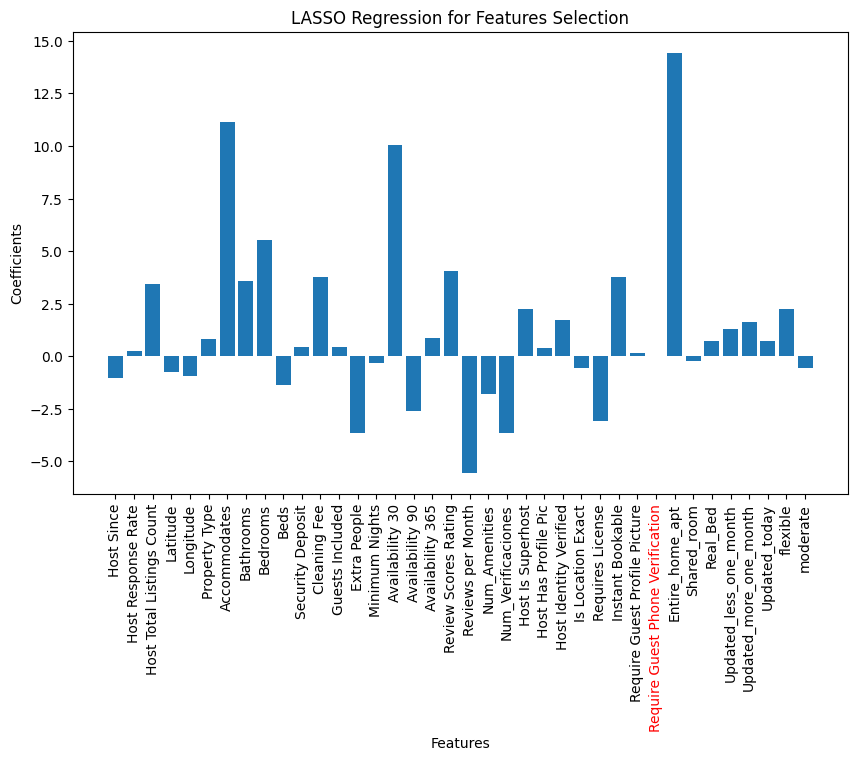

In [ ]:
w=modelo_LASSO.coef_
plt.figure(figsize=(10,6))
ax = plt.gca()
plt.bar([x for x in range(len(w))], w,align="center")
plt.xticks(range(len(w)),feature_names, rotation = 90)
labels = ax.get_xticklabels()
for label, wi in zip(labels, w):
  if wi == 0:
    label.set_color('r')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('LASSO Regression for Features Selection')
plt.show()

Vemos que un coeficiente es 0! Podemos eliminar esa variable del analisis.

In [ ]:
scaled_features_df.drop('Require Guest Phone Verification',axis=1,inplace=True)
X_sc = scaled_features_df.iloc[:, 0:37].values
y_sc = scaled_features_df['Price'].values
feature_names = scaled_features_df.columns[0:37]

from sklearn.model_selection import train_test_split

X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc, test_size=0.25, random_state=0)

X_train_sc.shape, X_test_sc.shape

((9251, 37), (3084, 37))

In [ ]:
vector_rmse.append(np.sqrt(mean_squared_error(y_test_sc, y_pred)))
vector_mse.append(mean_squared_error(y_test_sc, y_pred))
vector_mae.append(mean_absolute_error(y_test_sc, y_pred))
vector_r2_score.append(r2_score(y_test_sc, y_pred))

## 1.2 Regresion Ridge

La Regresión Rigde regulariza el modelo resultante imponiendo una penalización al tamaño de los coeficientes de la relación lineal entre las características predictivas y la variable objetivo. En este caso, los coeficientes calculados minimizan la suma de los cuadrados de los residuos penalizada al añadir el cuadrado de la norma L2 del vector formado por los coeficientes:

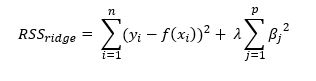


donde λ es un parámetro que controla el grado de penalización: cuanto mayor éste, los coeficientes serán menores resultando más robustos a la colinealidad. Cuando λ es igual a cero, Ridge es equivalente a la regresión lineal.

In [ ]:
# alpha seria el hiperparametro lambda
n_alphas = 25
alphas = np.logspace(-10, 1, n_alphas)
grid = GridSearchCV(Ridge(),param_grid = {'alpha': alphas}, 
        scoring='neg_root_mean_squared_error',
        n_jobs= multiprocessing.cpu_count() - 1,
        cv= RepeatedKFold(n_splits=10, n_repeats=7, random_state=123), 
        refit=True,verbose= 0,return_train_score = True)
grid.fit(X_train_sc, y_train_sc)

# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'alpha': 10.0} : -40.04716225632861 neg_root_mean_squared_error


,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
24,10.0,-40.047162,5.271292,-40.165433,0.587423
23,3.480701,-40.047596,5.270013,-40.165410,0.587423
22,1.211528,-40.047752,5.269565,-40.165407,0.587423
21,0.421697,-40.047808,5.269409,-40.165407,0.587423


In [ ]:
modelo_ridge= grid.best_estimator_
y_pred= modelo_ridge.predict(X = X_test_sc)
# Veamos los coeficientes obtenidos
print('Coefficients: \n', modelo_ridge.coef_)
# Termino independiente
print('Independent term: \n', modelo_ridge.intercept_)
# Error Cuadrado Medio
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test_sc, y_pred)))
print("MSE: %.2f" % mean_squared_error(y_test_sc, y_pred))
# Porcentaje de varianza representada
print('Variance score: %.2f' % r2_score(y_test_sc, y_pred))
# Error medio absoluto
print('MAE: %.2f' % mean_absolute_error(y_test_sc, y_pred))

Coefficients: 
 [-1.1419663   0.28766537  3.4447301  -0.85249808 -1.04762412  0.85487836
 11.26129101  3.64263872  5.5620836  -1.59164177  0.49368048  3.78930891
  0.4910015  -3.72356686 -0.35690081 10.35290143 -2.9543792   1.00588054
  4.10610983 -5.60552918 -1.87080804 -3.79384347  2.30810839  0.429742
  1.89854037 -0.65145305 -3.18152196  3.83500689  0.21585055 14.44767411
 -0.28666198  0.76719603  1.44649318  1.72625613  0.8531936   2.27480394
 -0.58829419]
Independent term: 
 61.533090059316315
RMSE: 42.51
MSE: 1806.93
Variance score: 0.30
MAE: 21.09


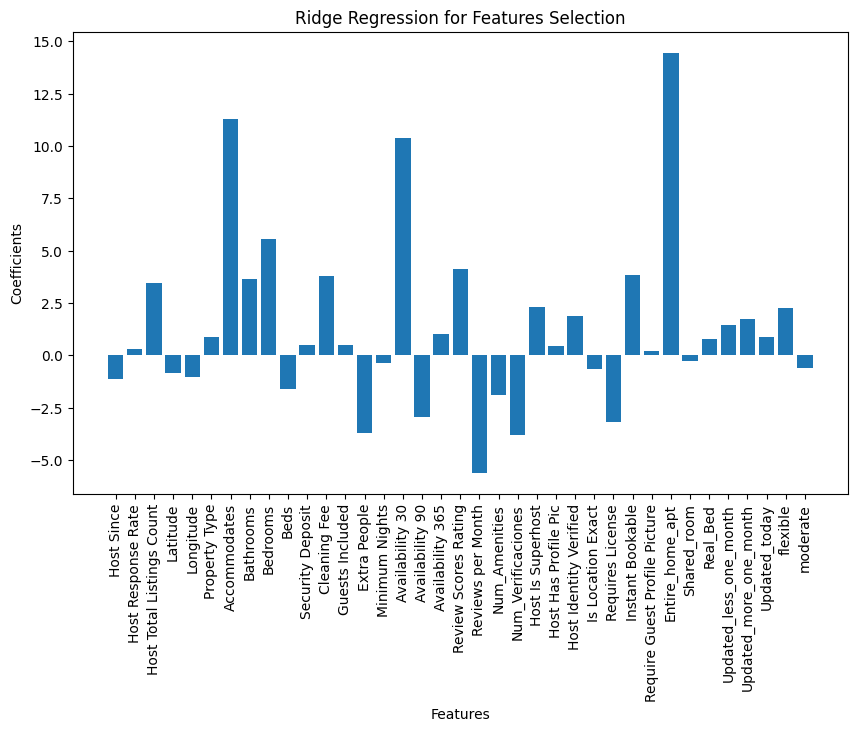

In [ ]:
w=modelo_ridge.coef_
plt.figure(figsize=(10,6))
ax = plt.gca()
plt.bar([x for x in range(len(w))], w,align="center")
plt.xticks(range(len(w)),feature_names, rotation = 90)
labels = ax.get_xticklabels()
for label, wi in zip(labels, w):
  if wi == 0:
    label.set_color('r')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Ridge Regression for Features Selection')
plt.show()

In [ ]:
vector_rmse.append(np.sqrt(mean_squared_error(y_test_sc, y_pred)))
vector_mse.append(mean_squared_error(y_test_sc, y_pred))
vector_mae.append(mean_absolute_error(y_test_sc, y_pred))
vector_r2_score.append(r2_score(y_test_sc, y_pred))

## 1.3 Regresion Multiple

A diferencia de los modelos anteriores, aquí se realiza el ajuste por mínimos cuadrados sin incorporar ninguna penalización a dicho ajuste. 

In [ ]:
from sklearn import linear_model
from sklearn.feature_selection import RFE
regr = LinearRegression()

In [ ]:
hyper_params = [{'n_features_to_select': list(range(1, 38))}]

lm = LinearRegression()
lm.fit(X_train_sc, y_train_sc)
rfe = RFE(lm)             

grid = GridSearchCV(estimator = rfe,
                    param_grid = hyper_params,
                    scoring= 'neg_root_mean_squared_error',
                    n_jobs= multiprocessing.cpu_count() - 1,
                    cv= RepeatedKFold(n_splits=10, n_repeats=7, random_state=123), 
                    refit=True,verbose= 0,return_train_score = True)
grid.fit(X_train_sc, y_train_sc)

# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'n_features_to_select': 37} : -40.04783732019752 neg_root_mean_squared_error


,param_n_features_to_select,mean_test_score,std_test_score,mean_train_score,std_train_score
36,37,-40.047837,5.269326,-40.165407,0.587423
35,36,-40.050898,5.268544,-40.165706,0.587458
34,35,-40.054286,5.268703,-40.166390,0.587597
33,34,-40.056972,5.269014,-40.167478,0.587803


In [ ]:
regr= grid.best_estimator_
y_pred= regr.predict(X = X_test_sc)

In [ ]:
# Veamos los coeficientes obtenidos
print('Coefficients: \n', regr.estimator_.coef_)
# Termino independiente
print('Independent term: \n', regr.estimator_.intercept_)
# Error Cuadrado Medio
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test_sc, y_pred)))
print("MSE: %.2f" % mean_squared_error(y_test_sc, y_pred))
# Porcentaje de varianza representada
print('Variance score: %.2f' % r2_score(y_test_sc, y_pred))
# Error medio absoluto
print('MAE: %.2f' % mean_absolute_error(y_test_sc, y_pred))

Coefficients: 
 [-1.14461268  0.28939951  3.44331897 -0.85563299 -1.05058235  0.85660377
 11.28700337  3.65115581  5.5663521  -1.61834397  0.48993355  3.78716379
  0.48541776 -3.72870294 -0.35809532 10.40554663 -3.00099357  1.01319832
  4.11235378 -5.61281328 -1.87434302 -3.80172047  2.31206841  0.43036691
  1.90718951 -0.65287934 -3.18481787  3.84040559  0.21756471 14.46749923
 -0.28393737  0.76831848  1.45076041  1.72571942  0.85300851  2.27726075
 -0.58689593]
Independent term: 
 61.53292595344887
RMSE: 42.51
MSE: 1807.03
Variance score: 0.30
MAE: 21.10


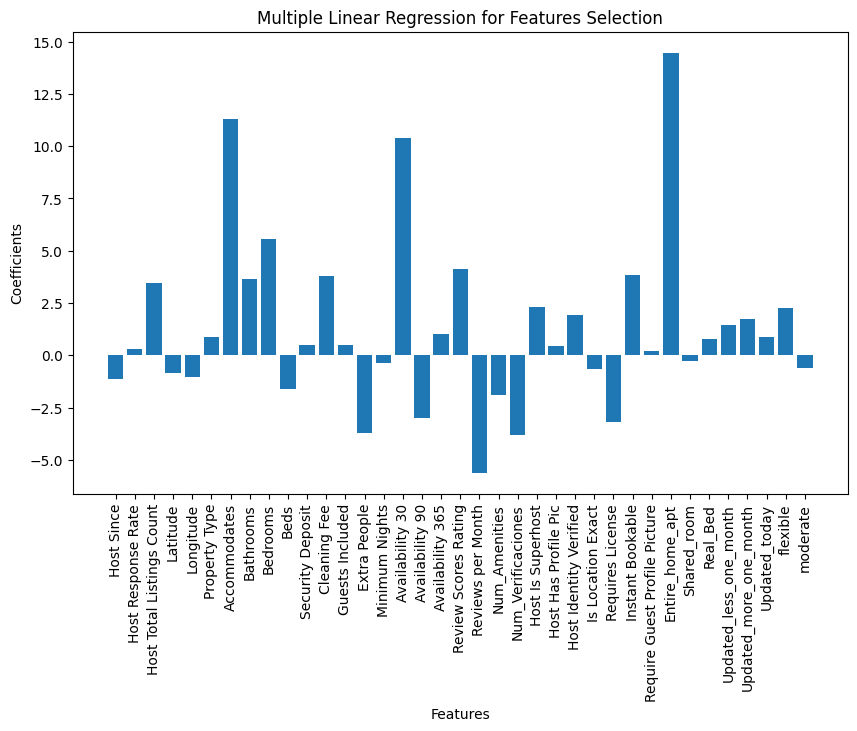

In [ ]:
w=regr.estimator_.coef_
plt.figure(figsize=(10,6))
ax = plt.gca()
plt.bar([x for x in range(len(w))], w,align="center")
plt.xticks(range(len(w)),feature_names, rotation = 90)
labels = ax.get_xticklabels()
for label, wi in zip(labels, w):
  if wi == 0:
    label.set_color('r')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Multiple Linear Regression for Features Selection')
plt.show()

In [ ]:
vector_rmse.append(np.sqrt(mean_squared_error(y_test_sc, y_pred)))
vector_mse.append(mean_squared_error(y_test_sc, y_pred))
vector_mae.append(mean_absolute_error(y_test_sc, y_pred))
vector_r2_score.append(r2_score(y_test_sc, y_pred))

## 1.4 Support Vector Regression

La regresión SVM o Support Vector Regression (SVR)  tiene como objetivo encontrar el hiperplano que se ajuste a los datos en un espacio continuo, en lugar de ajustar una recta. Este enfoque ayuda a reducir el error de predicción y permite que SVR maneje relaciones no lineales entre las variables de entrada y la variable objetivo  mediante una función kernel.

In [ ]:
param_grid = {'C': np.logspace(-5, 5, 20)}
grid = GridSearchCV(estimator  = SVR(kernel='rbf'),param_grid = param_grid, 
        scoring='neg_root_mean_squared_error',
        n_jobs= multiprocessing.cpu_count() - 1,
        cv=RepeatedKFold(n_splits=2, n_repeats=2, random_state=123) , 
        refit=True,verbose= 0,return_train_score = True)
grid.fit(X_train_sc, y_train_sc)

# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 784.7599703514607} : -33.327388844226746 neg_root_mean_squared_error


,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
15,784.75997,-33.327389,1.417231,-19.873677,2.580153
14,233.572147,-33.594758,1.736183,-25.645831,2.501458
16,2636.650899,-34.682898,1.319724,-15.733565,2.837100
13,69.51928,-36.746497,1.925113,-32.829519,2.157813


In [ ]:
modelo_svm= grid.best_estimator_
y_pred= modelo_svm.predict(X = X_test_sc)

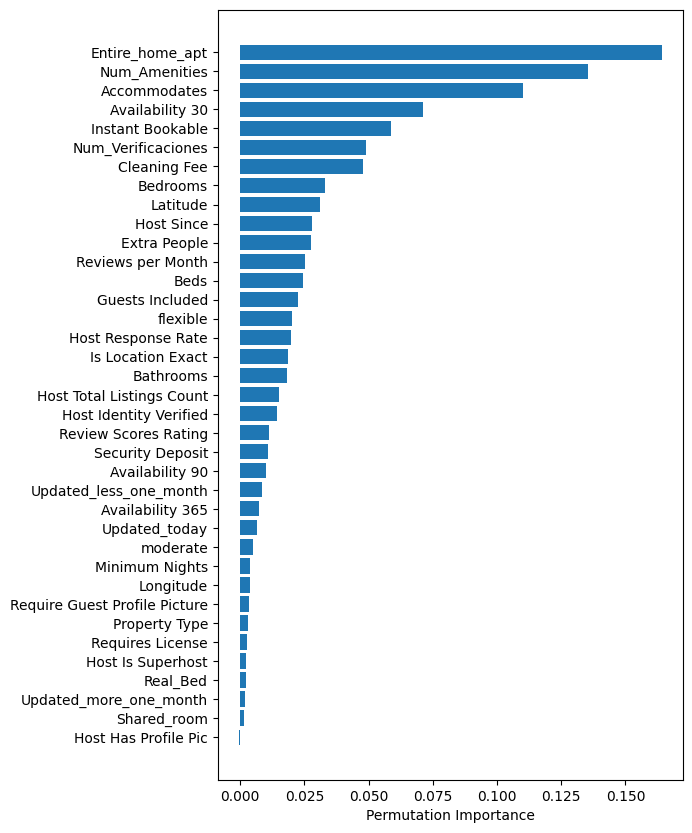

In [ ]:
from sklearn.inspection import permutation_importance
%matplotlib inline

perm_importance = permutation_importance(modelo_svm, X_test_sc, y_test_sc)
features = np.array(feature_names)

plt.figure(figsize=(6,10))
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

In [ ]:
# Error Cuadrado Medio
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test_sc, y_pred)))
print("MSE: %.2f" % mean_squared_error(y_test_sc, y_pred))
# Porcentaje de varianza representada
print('Variance score: %.2f' % r2_score(y_test_sc, y_pred))
# Error medio absoluto
print('MAE: %.2f' % mean_absolute_error(y_test_sc, y_pred))

RMSE: 36.00
MSE: 1296.22
Variance score: 0.50
MAE: 17.58


In [ ]:
vector_rmse.append(np.sqrt(mean_squared_error(y_test_sc, y_pred)))
vector_mse.append(mean_squared_error(y_test_sc, y_pred))
vector_mae.append(mean_absolute_error(y_test_sc, y_pred))
vector_r2_score.append(r2_score(y_test_sc, y_pred))

## 1.5 Regresion Logistica

En esta sección plantearemos otro problema distinto a las anteriores: nuestro objetivo será determinar si la disponibilidad mensual de un Airbnb es alta o no. Para ello plantearemos un modelo de regresión logística. 

La regresión logística es un modelo que predice la probabilidad de que una variable binaria tome un valor u otro en función del resto de variables. En nuestro caso, entrenaremos una regresión logística múltiple, ya que tenemos más de 1 variable independiente.


Para evaluar dicho modelo utilizaremos las siguientes métricas:
- **Matriz de Confusión**: representación matricial de las predicciones de nuestro modelo frente a los verdaderos valores de estas. La diagonal indica los valores que nuestro modelo y las demás posiciones indican los distintos tipos de errores cometidos.
- **Precision**: mide la capacidad del modelo de no crear falsos positivos. En la matriz de confusión para la primera categoría, correspondería al valor de la diagonal entre el valor de la diagonal más los otros valores de la columna
- **Recall**: es la capacidad del modelo de encontrar todos los valores de la misma categoría. En la matriz de confusión para la primera categoría, correspondería al valor de la diagonal entre el valor de la diagonal más los otros valores de la fila.
- **F-score**: media armónica entre Precision y Recall. Toma valores entre 0 y 1

En primer lugar, definiremos la variable respuesta a partir de la variable *Availability 30*. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import metrics

In [ ]:
df['Availability 30'].describe()

count    12335.000000
mean         8.567653
std          8.964876
min          0.000000
25%          0.000000
50%          6.000000
75%         13.000000
max         30.000000
Name: Availability 30, dtype: float64

Haremos una copia de nuestro dataset para abordar nuestro problema sin alterar los datos originales:

In [ ]:
datos=df.copy()

Creamos la variable objetivo que es Tipo de disponibilidad. Entendemos que disponibilidad alta es cuando el Airbnb está libre en 8 o más días del mes y disponibilidad baja en caso contrario. En nuestro caso, el 0 representa la disponibilidad baja y el 1 la disponibilidad alta.

In [ ]:
datos['Tipo_disponibilidad']=np.where(df['Availability 30']<8,0,1)

In [ ]:
datos['Tipo_disponibilidad'].value_counts()

0    7004
1    5331
Name: Tipo_disponibilidad, dtype: int64

Pondremos en primer lugar la variable Tipo_disponibilidad al tratarse de nuestra variable objetivo, después eliminaremos las variables Availability 30, 60 y 365.

In [ ]:
datos.drop(['Availability 30','Availability 90','Availability 365'] , axis=1,inplace=True)
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12335 entries, 0 to 12334
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Price                             12335 non-null  float64
 1   Host Since                        12335 non-null  float64
 2   Host Response Rate                12335 non-null  float64
 3   Host Total Listings Count         12335 non-null  float64
 4   Latitude                          12335 non-null  float64
 5   Longitude                         12335 non-null  float64
 6   Property Type                     12335 non-null  int64  
 7   Accommodates                      12335 non-null  int64  
 8   Bathrooms                         12335 non-null  float64
 9   Bedrooms                          12335 non-null  float64
 10  Beds                              12335 non-null  float64
 11  Security Deposit                  12335 non-null  float64
 12  Clea

In [ ]:
cols=['Tipo_disponibilidad','Price', 'Host Since', 'Host Response Rate',
       'Host Total Listings Count', 'Latitude', 'Longitude', 'Property Type',
       'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Security Deposit',
       'Cleaning Fee', 'Guests Included', 'Extra People', 'Minimum Nights',
       'Review Scores Rating', 'Reviews per Month', 'Num_Amenities',
       'Num_Verificaciones', 'Host Is Superhost', 'Host Has Profile Pic',
       'Host Identity Verified', 'Is Location Exact', 'Requires License',
       'Instant Bookable', 'Require Guest Profile Picture',
       'Require Guest Phone Verification', 'Entire_home_apt', 'Shared_room',
       'Real_Bed', 'Updated_less_one_month', 'Updated_more_one_month',
       'Updated_today', 'flexible', 'moderate']

In [ ]:
datos=datos.reindex(columns=cols)
datos.head(5)

,Tipo_disponibilidad,Price,Host Since,Host Response Rate,Host Total Listings Count,Latitude,Longitude,Property Type,Accommodates,Bathrooms,...,Require Guest Profile Picture,Require Guest Phone Verification,Entire_home_apt,Shared_room,Real_Bed,Updated_less_one_month,Updated_more_one_month,Updated_today,flexible,moderate
0,0,149.0,7.0,99.0,207.0,41.388685,2.155150,0,5,1.0,...,0,0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0,106.0,7.0,99.0,207.0,41.382537,2.149577,0,6,1.0,...,0,0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,1,45.0,11.0,100.0,1.0,41.402357,2.171119,0,2,1.0,...,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0,100.0,8.0,100.0,1.0,52.366679,4.865595,0,2,1.0,...,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0,115.0,10.0,90.0,1.0,41.381369,2.180874,0,3,2.0,...,0,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


Procedemos a dividir los datos en los conjuntos de entrenamiento y test y a estandarizar los datos.

In [ ]:
data1 = datos.values 

y1 = data1[:,0:1]     # nos quedamos con la 1ª columna
X1 = data1[:,1:]      # nos quedamos con el resto

feature_names = datos.columns[1:]

In [ ]:
scaled_features = StandardScaler().fit_transform(X1, y1)

In [ ]:
scaled_features_datos = pd.DataFrame(scaled_features, index=datos.index, columns=datos.iloc[:,1:].columns)
scaled_features_datos['Tipo_disponibilidad']= y1
scaled_features_datos.head()

,Price,Host Since,Host Response Rate,Host Total Listings Count,Latitude,Longitude,Property Type,Accommodates,Bathrooms,Bedrooms,...,Require Guest Phone Verification,Entire_home_apt,Shared_room,Real_Bed,Updated_less_one_month,Updated_more_one_month,Updated_today,flexible,moderate,Tipo_disponibilidad
0,1.764567,-1.029626,0.279649,7.007328,0.458549,0.926851,-0.380202,1.353587,-0.375841,1.310284,...,-0.156258,0.833846,-0.092658,0.147026,-0.654085,-0.45686,1.733081,1.430010,-0.666364,0.0
1,0.894774,-1.029626,0.279649,7.007328,0.455521,0.925972,-0.380202,2.003661,-0.375841,1.310284,...,-0.156258,0.833846,-0.092658,0.147026,1.528853,-0.45686,-0.577007,-0.699296,-0.666364,0.0
2,-0.339118,1.446938,0.356166,-0.295494,0.465282,0.929370,-0.380202,-0.596634,-0.375841,-0.282537,...,-0.156258,-1.199262,-0.092658,0.147026,-0.654085,-0.45686,-0.577007,1.430010,-0.666364,1.0
3,0.773408,-0.410485,0.356166,-0.295494,5.865328,1.354453,-0.380202,-0.596634,-0.375841,-0.282537,...,-0.156258,-1.199262,-0.092658,0.147026,1.528853,-0.45686,-0.577007,-0.699296,1.500681,0.0
4,1.076824,0.827797,-0.409008,-0.295494,0.454945,0.930909,-0.380202,0.053439,1.686437,-0.282537,...,-0.156258,0.833846,-0.092658,0.147026,1.528853,-0.45686,-0.577007,1.430010,-0.666364,0.0


In [ ]:
X_sc1 = scaled_features_datos.iloc[:, 0:36].values
y_sc1 = scaled_features_datos['Tipo_disponibilidad'].values

from sklearn.model_selection import train_test_split

X_train_sc1, X_test_sc1, y_train_sc1, y_test_sc1 = train_test_split(X_sc1, y_sc1, test_size=0.3, random_state=0)

X_train_sc1.shape, X_test_sc1.shape

((8634, 36), (3701, 36))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
param_grid = {'C': np.logspace(-5, 5, 25),'penalty':['l1', 'l2', 'elasticnet']}
logreg = LogisticRegression()
grid = GridSearchCV(estimator = logreg,
                    param_grid=param_grid,
                    scoring= 'accuracy',
                    n_jobs= multiprocessing.cpu_count() - 1,
                    cv= RepeatedKFold(n_splits=10, n_repeats=7, random_state=123), 
                    refit=True,verbose= 0,return_train_score = True)
grid.fit(X_train_sc1, y_train_sc1)

# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 2.6101572156825386, 'penalty': 'l2'} : 0.6268571972692774 accuracy


,param_C,param_penalty,mean_test_score,std_test_score,mean_train_score,std_train_score
40,2.610157,l2,0.626857,0.016299,0.632362,0.002148
73,100000.0,l2,0.626857,0.016319,0.632349,0.002138
70,38311.868496,l2,0.626857,0.016319,0.632349,0.002138
67,14677.992676,l2,0.626857,0.016319,0.632349,0.002138


In [ ]:
logistic_reg= grid.best_estimator_
y_pred= logistic_reg.predict(X = X_test_sc1)

In [ ]:
clasificacion = np.where(y_pred<0.5, 0, 1)
print(classification_report(y_test_sc1, clasificacion))

              precision    recall  f1-score   support

         0.0       0.63      0.78      0.70      2071
         1.0       0.60      0.42      0.49      1630

    accuracy                           0.62      3701
   macro avg       0.61      0.60      0.59      3701
weighted avg       0.62      0.62      0.61      3701



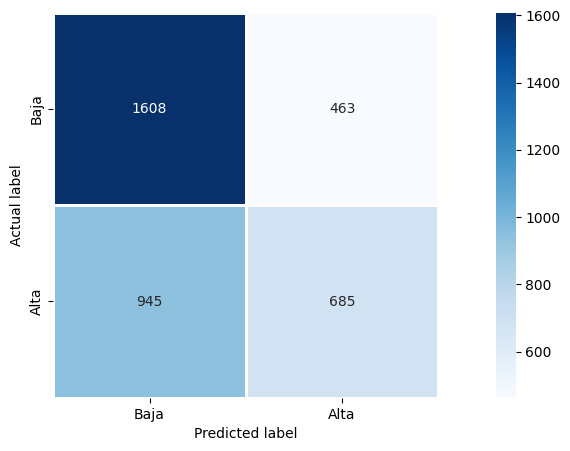

In [ ]:
C = metrics.confusion_matrix(y_test_sc1, clasificacion)
plt.figure(figsize=(15,5))
sns.heatmap(data=C,linewidths=1, annot=True, square = True,  cmap = 'Blues',fmt='g',xticklabels=['Baja', 'Alta'],yticklabels=['Baja', 'Alta'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Se puede observar que un alto porcentaje de las predicciones estarían correctamente clasificadas en la clase baja, aunque 463 observaciones que pertenecen a la clase baja se clasificarían en la clase alta. Sin embargo, se observa que el modelo clasifica peor la clase alta, ya que 945 predicciones que deberían estar en clase alta están en clase baja.
Podrian mejorarse los resultados aplicando tecnicas de balanceo de la muestra (como SMOTE o random UnderSampling). 

**Curva ROC**

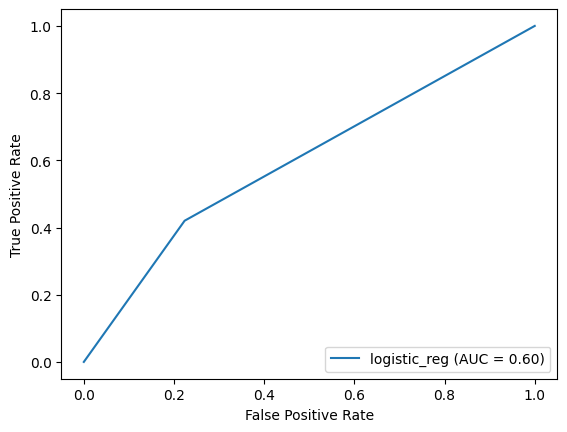

In [ ]:
from sklearn.metrics import RocCurveDisplay
fpr, tpr, thresholds = metrics.roc_curve(y_test_sc1, clasificacion)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logistic_reg')
display.plot()
plt.show()

**Curva PR**

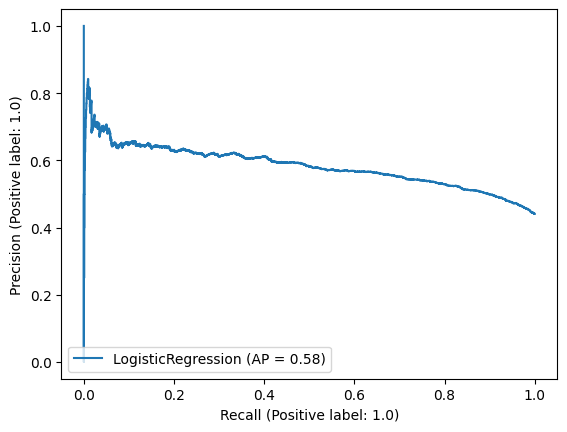

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
PrecisionRecallDisplay.from_estimator(logistic_reg, X_test_sc1, y_test_sc1)
plt.show()

# 2. Comparativa de distintos modelos

In [ ]:
metricas=pd.DataFrame(columns=['RMSE','R2','MAE'],index=['LASSO','Ridge','Regresion Multiple','SVR'])
metricas['RMSE']=vector_rmse
metricas['MSE']=vector_mse
metricas['MAE']=vector_mae
metricas['R2']=vector_r2_score

In [ ]:
metricas

,RMSE,R2,MAE,MSE
LASSO,42.488001,0.301412,21.014290,1805.230243
Ridge,42.508022,0.300753,21.092778,1806.931917
Regresion Multiple,42.509139,0.300717,21.100322,1807.026926
SVR,36.003000,0.498390,17.580858,1296.216024


Podemos observar que el modelo con mejores métricas es claramente el SVR. Esto coincide con lo que cabria esperar, ya que es el algoritmo más potente de los evaluados. Sin embargo, cabe destacar que sus resultados se han obtenido con validación cruzada al igual que los demás, pero con un k inferior a los otros modelos (usamos k=2 y 2 repeticiones en lugar de k=10 y 7 repeticiones como en los demás) debido a que era inviable evaluarlo de igual forma debido a su coste computacional.
